⚠️ 00summary_excerpt_results.csv 처리 중 오류 발생: No columns to parse from file
H30A15D2_Peak value: 95.13 V
H30A15D2_Peak number: 13개
H30A15D2_표준편차: 3.47
H30A15D2_주파수: 3.37 Hz
👉 H30A15D2 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 296.18
   - 발췌 평균 Peak value: 97.98 V (표준편차: 3.10 V)
   - 발췌 평균 주파수: 3.42 Hz


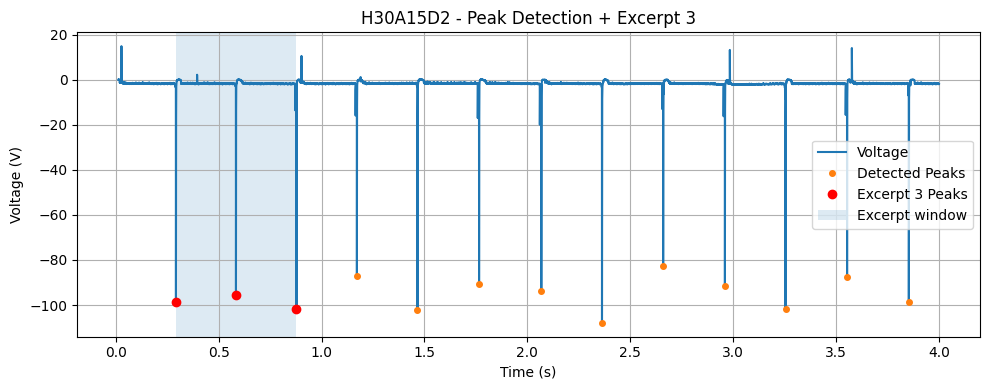

H30A15D4_Peak value: 9.03 V
H30A15D4_Peak number: 18개
H30A15D4_표준편차: 4.65
H30A15D4_주파수: 5.91 Hz
👉 H30A15D4 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 45.31
   - 발췌 평균 Peak value: 13.85 V (표준편차: 13.13 V)
   - 발췌 평균 주파수: 4.41 Hz


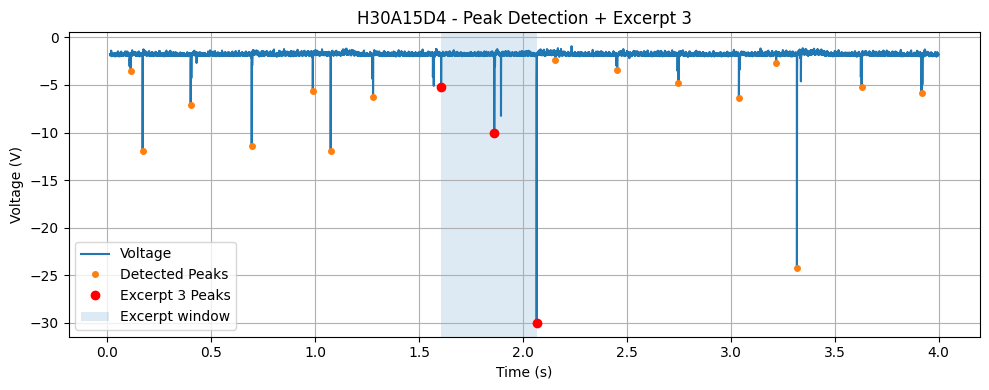

H30A15D6_Peak value: 6.62 V
H30A15D6_Peak number: 16개
H30A15D6_표준편차: 3.50
H30A15D6_주파수: 4.55 Hz
👉 H30A15D6 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 32.59
   - 발췌 평균 Peak value: 9.31 V (표준편차: 9.28 V)
   - 발췌 평균 주파수: 4.33 Hz


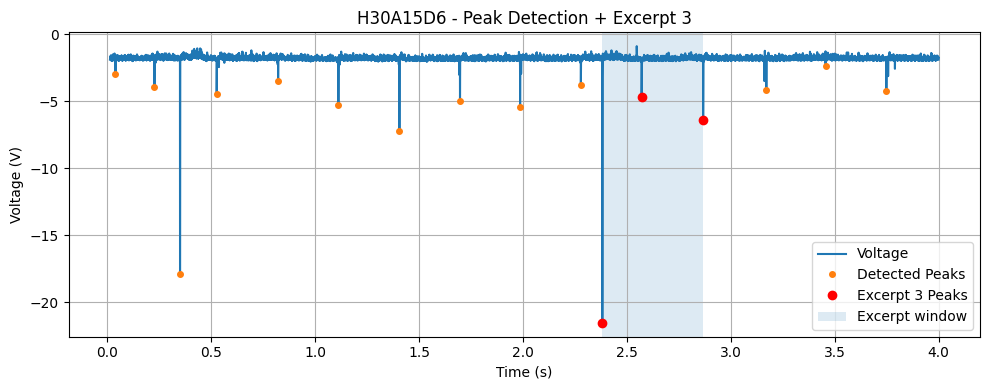

H30A15D8_Peak value: 10.88 V
H30A15D8_Peak number: 15개
H30A15D8_표준편차: 10.65
H30A15D8_주파수: 3.98 Hz
👉 H30A15D8 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 76.80
   - 발췌 평균 Peak value: 20.87 V (표준편차: 34.33 V)
   - 발췌 평균 주파수: 6.45 Hz


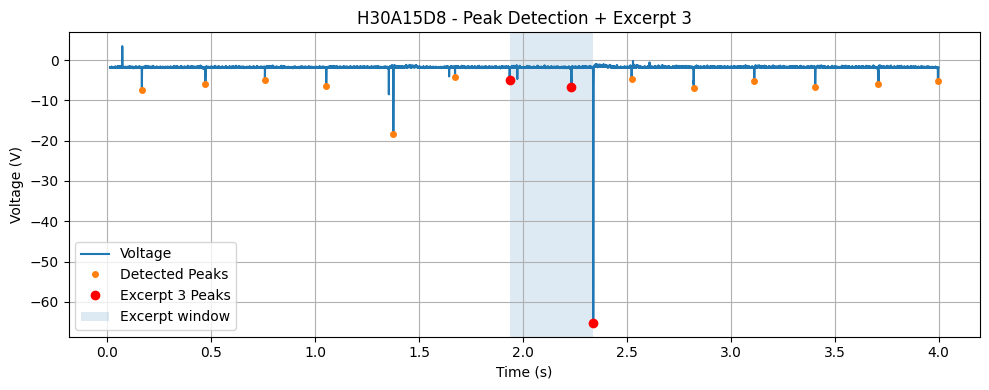

H30A30D2_Peak value: 96.32 V
H30A30D2_Peak number: 14개
H30A30D2_표준편차: 3.79
H30A30D2_주파수: 3.41 Hz
👉 H30A30D2 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 304.97
   - 발췌 평균 Peak value: 99.72 V (표준편차: 6.69 V)
   - 발췌 평균 주파수: 3.41 Hz


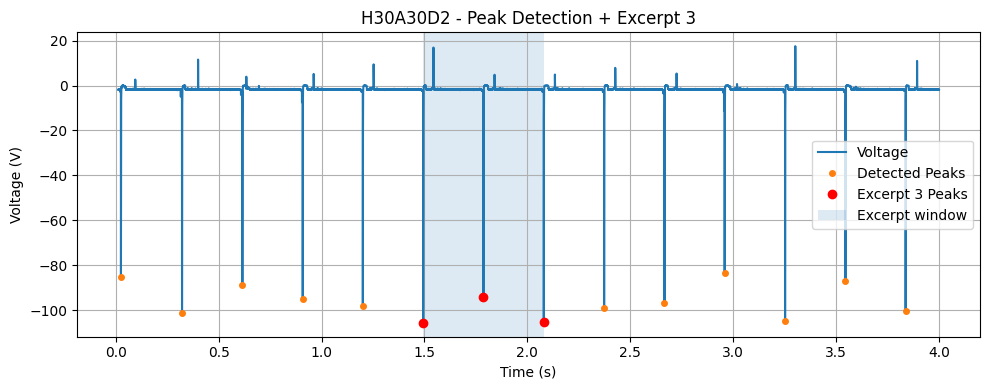

H30A30D4_Peak value: 22.41 V
H30A30D4_Peak number: 12개
H30A30D4_표준편차: 26.30
H30A30D4_주파수: 4.76 Hz
👉 H30A30D4 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 167.88
   - 발췌 평균 Peak value: 75.33 V (표준편차: 67.13 V)
   - 발췌 평균 주파수: 4.85 Hz


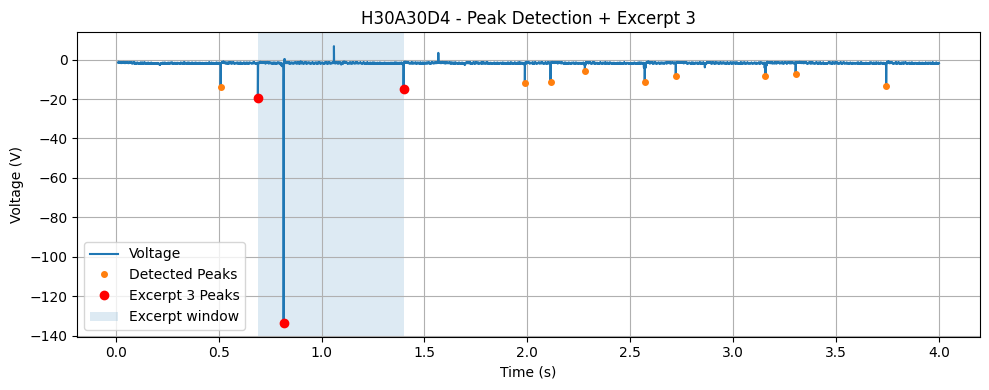

H30A30D6_Peak value: 11.27 V
H30A30D6_Peak number: 18개
H30A30D6_표준편차: 7.64
H30A30D6_주파수: 5.68 Hz
👉 H30A30D6 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 61.07
   - 발췌 평균 Peak value: 19.33 V (표준편차: 18.32 V)
   - 발췌 평균 주파수: 4.61 Hz


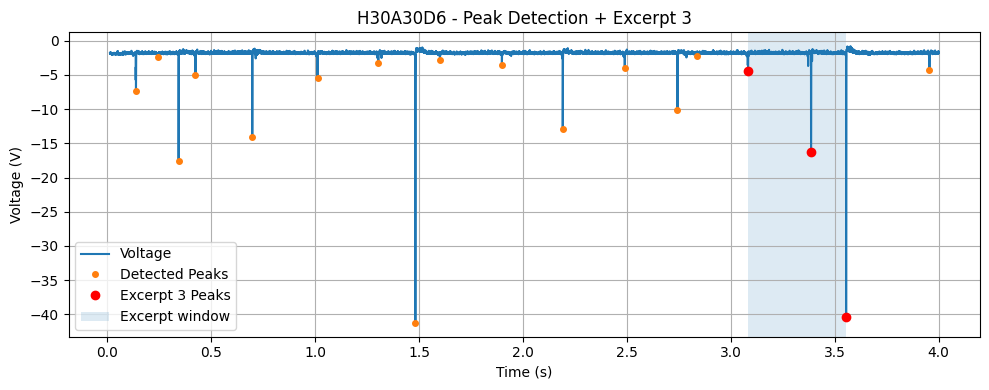

H30A30D8_Peak value: 10.65 V
H30A30D8_Peak number: 15개
H30A30D8_표준편차: 4.40
H30A30D8_주파수: 5.00 Hz
👉 H30A30D8 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 52.92
   - 발췌 평균 Peak value: 14.23 V (표준편차: 13.95 V)
   - 발췌 평균 주파수: 3.17 Hz


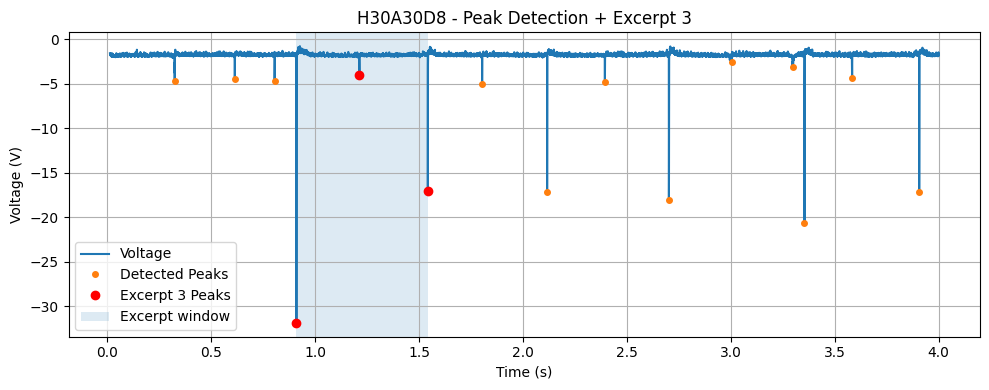

H30A45D2_Peak value: 102.21 V
H30A45D2_Peak number: 14개
H30A45D2_표준편차: 2.12
H30A45D2_주파수: 3.36 Hz
👉 H30A45D2 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 311.59
   - 발췌 평균 Peak value: 102.96 V (표준편차: 6.27 V)
   - 발췌 평균 주파수: 3.41 Hz


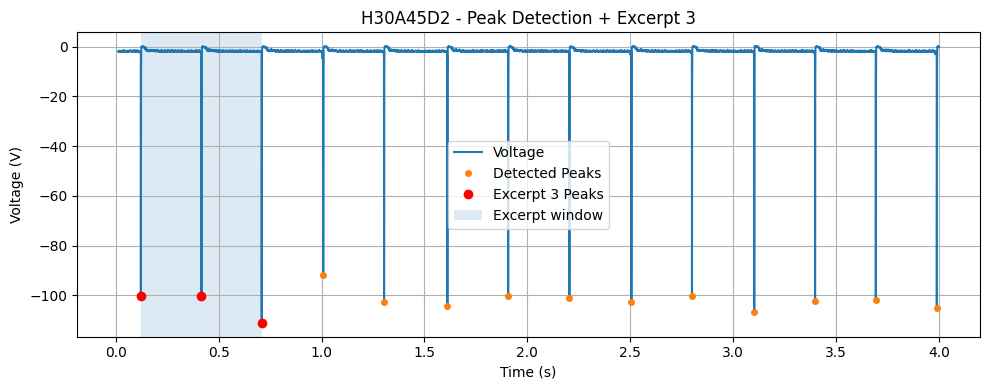

H30A45D4_Peak value: 16.83 V
H30A45D4_Peak number: 15개
H30A45D4_표준편차: 19.51
H30A45D4_주파수: 5.04 Hz
👉 H30A45D4 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 167.23
   - 발췌 평균 Peak value: 43.59 V (표준편차: 52.55 V)
   - 발췌 평균 주파수: 3.67 Hz


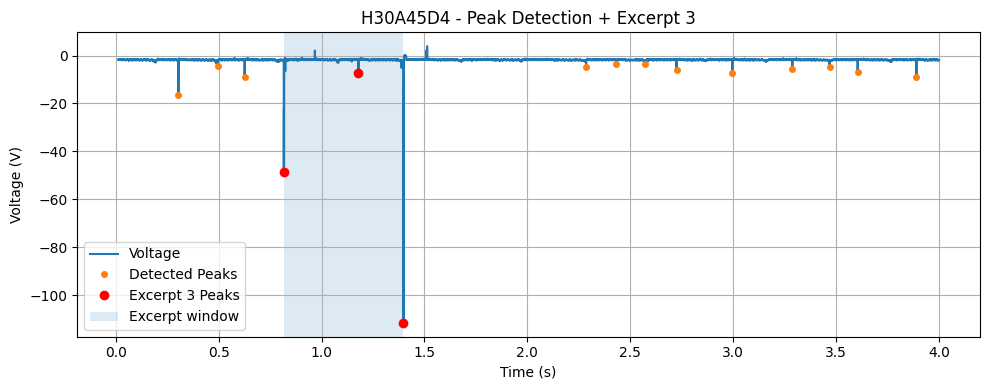

H30A45D6_Peak value: 10.45 V
H30A45D6_Peak number: 16개
H30A45D6_표준편차: 3.37
H30A45D6_주파수: 5.16 Hz
👉 H30A45D6 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 45.46
   - 발췌 평균 Peak value: 14.19 V (표준편차: 3.65 V)
   - 발췌 평균 주파수: 3.45 Hz


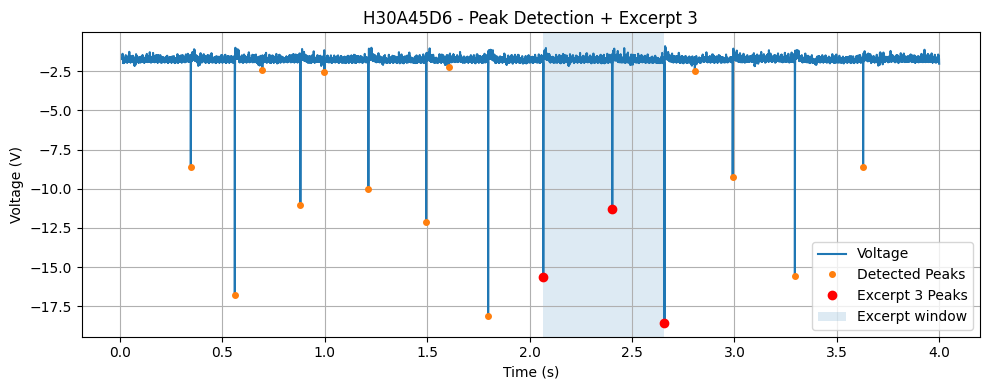

H30A45D8_Peak value: 13.10 V
H30A45D8_Peak number: 14개
H30A45D8_표준편차: 4.65
H30A45D8_주파수: 4.33 Hz
👉 H30A45D8 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 58.20
   - 발췌 평균 Peak value: 17.45 V (표준편차: 11.58 V)
   - 발췌 평균 주파수: 3.75 Hz


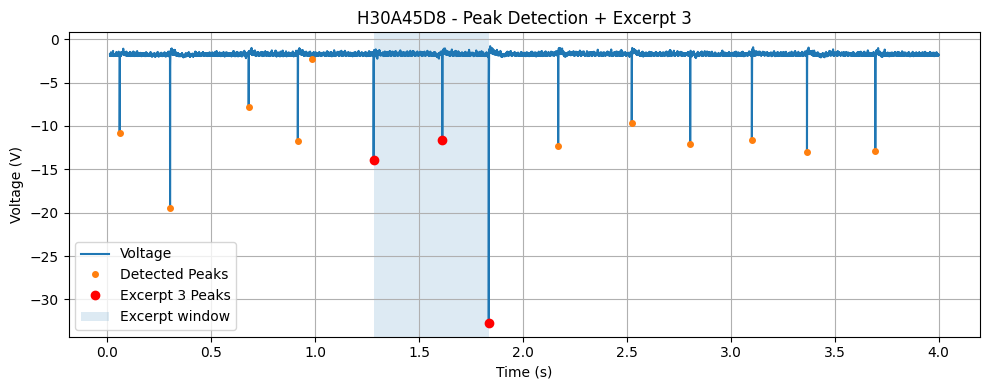

H30A60D2_Peak value: 72.06 V
H30A60D2_Peak number: 13개
H30A60D2_표준편차: 0.98
H30A60D2_주파수: 3.27 Hz
👉 H30A60D2 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 218.98
   - 발췌 평균 Peak value: 73.19 V (표준편차: 0.71 V)
   - 발췌 평균 주파수: 3.30 Hz


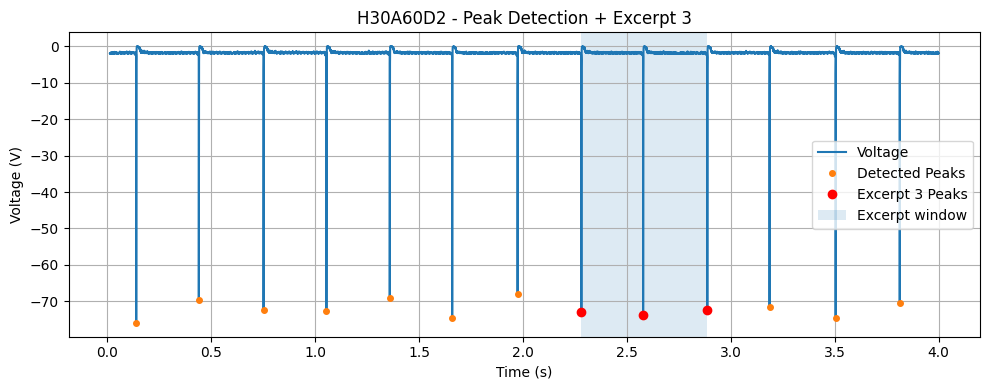

H30A60D4_Peak value: 104.93 V
H30A60D4_Peak number: 14개
H30A60D4_표준편차: 3.00
H30A60D4_주파수: 3.28 Hz
👉 H30A60D4 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 322.50
   - 발췌 평균 Peak value: 107.19 V (표준편차: 5.21 V)
   - 발췌 평균 주파수: 3.26 Hz


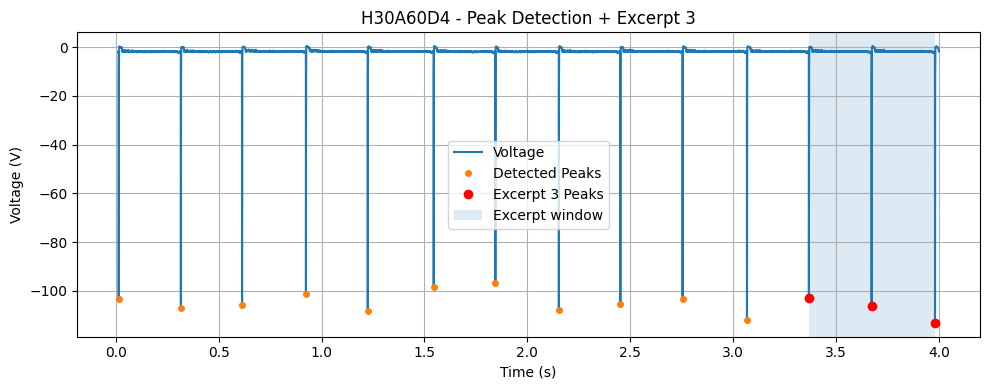

H30A60D6_Peak value: 33.73 V
H30A60D6_Peak number: 19개
H30A60D6_표준편차: 17.28
H30A60D6_주파수: 8.19 Hz
👉 H30A60D6 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 166.92
   - 발췌 평균 Peak value: 52.64 V (표준편차: 17.12 V)
   - 발췌 평균 주파수: 3.25 Hz


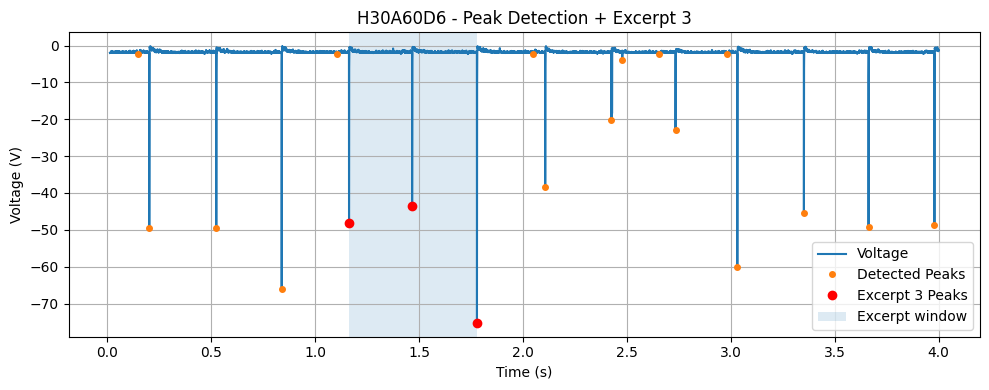

H30A60D8_Peak value: 26.06 V
H30A60D8_Peak number: 20개
H30A60D8_표준편차: 15.89
H30A60D8_주파수: 7.05 Hz
👉 H30A60D8 발췌(연속 3개) 정보
   - 합계(피크 크기 합): 125.64
   - 발췌 평균 Peak value: 32.14 V (표준편차: 35.78 V)
   - 발췌 평균 주파수: 7.73 Hz


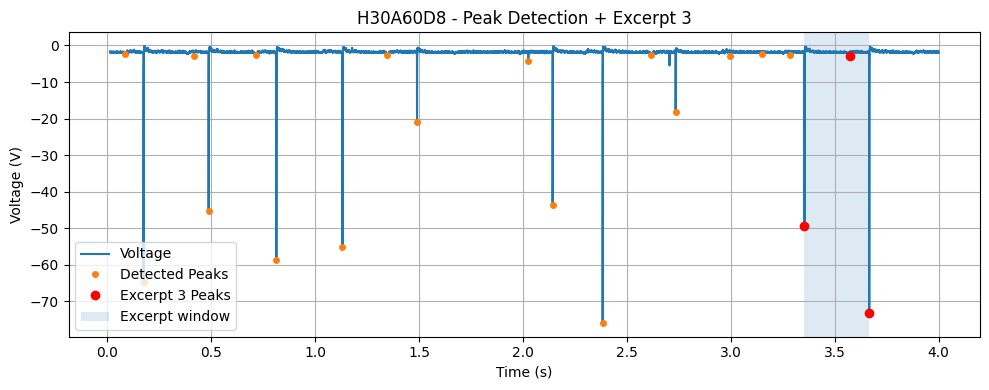


🎯 모든 파일 발췌 결과 요약 (연속 3개 피크 기준)
00summary_excerpt_results.csv | Peak value: 97.98 V | 표준편차: 3.10 V | 주파수: 3.42 Hz
H30A15D2.csv | Peak value: 13.85 V | 표준편차: 13.13 V | 주파수: 4.41 Hz
H30A15D4.csv | Peak value: 9.31 V | 표준편차: 9.28 V | 주파수: 4.33 Hz
H30A15D6.csv | Peak value: 20.87 V | 표준편차: 34.33 V | 주파수: 6.45 Hz
H30A15D8.csv | Peak value: 99.72 V | 표준편차: 6.69 V | 주파수: 3.41 Hz
H30A30D2.csv | Peak value: 75.33 V | 표준편차: 67.13 V | 주파수: 4.85 Hz
H30A30D4.csv | Peak value: 19.33 V | 표준편차: 18.32 V | 주파수: 4.61 Hz
H30A30D6.csv | Peak value: 14.23 V | 표준편차: 13.95 V | 주파수: 3.17 Hz
H30A30D8.csv | Peak value: 102.96 V | 표준편차: 6.27 V | 주파수: 3.41 Hz
H30A45D2.csv | Peak value: 43.59 V | 표준편차: 52.55 V | 주파수: 3.67 Hz
H30A45D4.csv | Peak value: 14.19 V | 표준편차: 3.65 V | 주파수: 3.45 Hz
H30A45D6.csv | Peak value: 17.45 V | 표준편차: 11.58 V | 주파수: 3.75 Hz
H30A45D8.csv | Peak value: 73.19 V | 표준편차: 0.71 V | 주파수: 3.30 Hz
H30A60D2.csv | Peak value: 107.19 V | 표준편차: 5.21 V | 주파수: 3.26 Hz
H30A60D4.csv | Peak value: 52.64 

In [3]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# ============================================================
# 사용자 설정
# ============================================================
# 피크 탐지 모드 선택: "neg" / "pos" / "both"
peak_mode = "neg"

# 데이터 폴더 경로
folder_path = r"G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\4. Data measurement\251108_진짜 마지막\0Figure1 Table\Angle_Conv"

# 피크 탐지 파라미터
prominence_ratio = 0.3        # prominence = 표준편차 * 비율
min_prominence = 0.1          # prominence 하한
min_distance_sec = 0.05       # 인접 피크 최소 간격 (초)
snr_threshold = 1             # SNR 기준
min_relative_height = 0.03    # 전체 최대 진폭 대비 최소 비율
abs_min_height = 2.2            # 최소 피크 height
window_peaks = 3              # 연속 피크 개수

# 그래프 Y축 범위 (None은 자동)
y_range = (None, None)
# y_range = (-150, 10)

# 결과 CSV 저장 여부
save_summary_csv = True

# ============================================================
# 파일 로드 및 초기 설정
# ============================================================
try:
    csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
except FileNotFoundError:
    print(f"❌ Error: Folder not found at {folder_path}")
    csv_files = []

all_analysis_values = []
file_std_values = []
all_freq_values = []

excerpt_mean_analysis_list = []
excerpt_std_analysis_list = []
excerpt_mean_freq_list = []

analysis_unit = "Vpp" if peak_mode == "both" else "Peak value"

# ============================================================
# 파일 반복 루프
# ============================================================
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)

    try:
        # 데이터 로드
        df = pd.read_csv(file_path, skiprows=30)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values

        # 샘플링 속도 계산
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # 피크 탐지 prominence 기준
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)

        # ------------------------------------------------------------
        # 피크 탐지
        # ------------------------------------------------------------
        if peak_mode == "neg":
            raw_peaks, _ = find_peaks(-voltage, prominence=prom, distance=distance)
        elif peak_mode == "pos":
            raw_peaks, _ = find_peaks(voltage, prominence=prom, distance=distance)
        elif peak_mode == "both":
            raw_peaks_pos, _ = find_peaks(voltage, prominence=prom, distance=distance)
            raw_peaks_neg, _ = find_peaks(-voltage, prominence=prom, distance=distance)
            raw_peaks = np.sort(np.concatenate([raw_peaks_pos, raw_peaks_neg]))
        else:
            raise ValueError("peak_mode는 'neg', 'pos', 'both' 중 하나여야 합니다.")

        # ------------------------------------------------------------
        # 피크 필터링
        # ------------------------------------------------------------
        max_amplitude = np.max(np.abs(voltage)) if len(voltage) > 0 else 0.0
        final_peaks = []

        for i in raw_peaks:
            left = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = abs(voltage[i])

            if (
                signal > max_amplitude * min_relative_height and
                (signal / local_noise) > snr_threshold and
                signal > abs_min_height
            ):
                final_peaks.append(i)

        final_peaks = np.array(final_peaks, dtype=int)
        peak_times = time[final_peaks]

        # ------------------------------------------------------------
        # 분석 값 계산
        # ------------------------------------------------------------
        analysis_list = []
        for i in range(len(final_peaks) - 1):
            s, e = final_peaks[i], final_peaks[i + 1]
            if peak_mode == "both":
                analysis_val = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
            else:
                mag_i = abs(voltage[final_peaks[i]])
                mag_j = abs(voltage[final_peaks[i + 1]])
                analysis_val = (mag_i + mag_j) / 2
            analysis_list.append(analysis_val)

        if len(final_peaks) >= 2:
            mean_analysis = float(np.mean(analysis_list)) if analysis_list else 0.0
            std_analysis = float(np.std(analysis_list, ddof=1)) if len(analysis_list) > 1 else 0.0
        elif len(final_peaks) == 1:
            mean_analysis = abs(voltage[final_peaks[0]])
            std_analysis = 0.0
        else:
            mean_analysis = 0.0
            std_analysis = 0.0

        # 주파수 계산
        if len(peak_times) >= 2:
            periods = np.diff(peak_times)
            mean_freq = float(np.mean(1.0 / periods))
        else:
            mean_freq = 0.0

        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_{analysis_unit}: {mean_analysis:.2f} V")
        print(f"{base_name}_Peak number: {len(final_peaks)}개")
        print(f"{base_name}_표준편차: {std_analysis:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        all_analysis_values.append(mean_analysis)
        file_std_values.append(std_analysis)
        all_freq_values.append(mean_freq)

        # ------------------------------------------------------------
        # 발췌 윈도우 분석
        # ------------------------------------------------------------
        if len(final_peaks) >= window_peaks:
            peak_mags = np.abs(voltage[final_peaks]).astype(float)
            csum = np.cumsum(peak_mags)
            sums = csum[window_peaks - 1:] - np.concatenate(([0.0], csum[:-window_peaks]))
            best_start = int(np.argmax(sums))
            best_end = best_start + window_peaks

            excerpt_idx = final_peaks[best_start:best_end]
            excerpt_times = time[excerpt_idx]
            excerpt_mags = peak_mags[best_start:best_end]

            if window_peaks == 1:
                excerpt_mean_analysis = float(np.mean(excerpt_mags)) if len(excerpt_mags) > 0 else 0.0
                excerpt_std_analysis = float(np.std(excerpt_mags, ddof=1)) if len(excerpt_mags) > 1 else 0.0
            else:
                excerpt_analysis = []
                for j in range(window_peaks - 1):
                    s = excerpt_idx[j]
                    e = excerpt_idx[j + 1]
                    if peak_mode == "both":
                        analysis_seg = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
                    else:
                        mag_i = abs(voltage[excerpt_idx[j]])
                        mag_j = abs(voltage[excerpt_idx[j + 1]])
                        analysis_seg = (mag_i + mag_j) / 2
                    excerpt_analysis.append(analysis_seg)

                excerpt_mean_analysis = np.mean(excerpt_analysis) if excerpt_analysis else 0.0
                if analysis_unit == "Vpp":
                    excerpt_std_analysis = np.std(excerpt_analysis, ddof=1) if len(excerpt_analysis) > 1 else 0.0
                else:
                    excerpt_std_analysis = np.std(excerpt_mags, ddof=1) if len(excerpt_mags) > 1 else 0.0

            if len(excerpt_times) >= 2:
                excerpt_periods = np.diff(excerpt_times)
                excerpt_mean_freq = float(np.mean(1.0 / excerpt_periods))
            else:
                excerpt_mean_freq = 0.0

            print(f"👉 {base_name} 발췌(연속 {window_peaks}개) 정보")
            print(f"   - 합계(피크 크기 합): {np.sum(excerpt_mags):.2f}")
            print(f"   - 발췌 평균 {analysis_unit}: {excerpt_mean_analysis:.2f} V (표준편차: {excerpt_std_analysis:.2f} V)")
            print(f"   - 발췌 평균 주파수: {excerpt_mean_freq:.2f} Hz")

            excerpt_mean_analysis_list.append(excerpt_mean_analysis)
            excerpt_std_analysis_list.append(excerpt_std_analysis)
            excerpt_mean_freq_list.append(excerpt_mean_freq)

            # 그래프 표시
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage')
            plt.plot(time[final_peaks], voltage[final_peaks], 'o', ms=4, label='Detected Peaks')
            plt.plot(time[excerpt_idx], voltage[excerpt_idx], 'ro', ms=6, label=f'Excerpt {window_peaks} Peaks')
            plt.axvspan(time[excerpt_idx[0]], time[excerpt_idx[-1]], alpha=0.15, label='Excerpt window')
            plt.title(f"{base_name} - Peak Detection + Excerpt {window_peaks}")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage', color='gray')
            plt.plot(time[final_peaks], voltage[final_peaks], 'ro', ms=4, label='Detected Peaks')
            plt.title(f"{base_name} - Not enough peaks for excerpt")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"⚠️ {file_name} 처리 중 오류 발생: {e}")

# ============================================================
# 전체 요약 출력 및 CSV 저장
# ============================================================
print("\n==============================")
print(f"🎯 모든 파일 발췌 결과 요약 (연속 {window_peaks}개 피크 기준)")

for i in range(len(excerpt_mean_analysis_list)):
    if i < len(csv_files):
        print(f"{csv_files[i]} | {analysis_unit}: {excerpt_mean_analysis_list[i]:.2f} V | "
              f"표준편차: {excerpt_std_analysis_list[i]:.2f} V | "
              f"주파수: {excerpt_mean_freq_list[i]:.2f} Hz")

if excerpt_mean_analysis_list:
    avg_analysis = float(np.mean(excerpt_mean_analysis_list))
    avg_std = float(np.std(excerpt_mean_analysis_list, ddof=1)) if len(excerpt_mean_analysis_list) > 1 else 0.0
    avg_freq = float(np.mean(excerpt_mean_freq_list))

    print("\n==============================")
    print(f"📊 전체 평균 {analysis_unit}: {avg_analysis:.2f} V")
    print(f"📉 평균 표준편차: {avg_std:.2f} V")
    print(f"🎵 평균 주파수: {avg_freq:.2f} Hz")

    if save_summary_csv:
        summary_df = pd.DataFrame({
            "File": csv_files[:len(excerpt_mean_analysis_list)],
            analysis_unit.replace(" ", "_"): excerpt_mean_analysis_list,
            "Std": excerpt_std_analysis_list,
            "Freq": excerpt_mean_freq_list
        })
        summary_df.loc[len(summary_df)] = ["ALL_AVG", avg_analysis, avg_std, avg_freq]
        output_path = os.path.join(folder_path, "00summary_excerpt_results.csv")
        summary_df.to_csv(output_path, index=False, encoding="utf-8-sig")
        print(f"✅ 요약 결과 CSV 저장 완료: {output_path}")
else:
    print("📭 데이터가 없습니다.")
